## Hough変換・直線検出 (Step.2) NMS

In [9]:
import cv2 
import numpy as  np
import matplotlib.pyplot as plt

def Canny_step3(img):

    # Gray scale
    def BGR2GRAY(img):
        b = img[:, :, 0].copy()
        g = img[:, :, 1].copy()
        r = img[:, :, 2].copy()

        # Gray scale
        out = 0.2126 * r + 0.7152 * g + 0.0722 * b
        out = out.astype(np.uint8)
        return out
    
    
    # Gaussian filter for grayscale
    def gaussian_filter(img, K_size=3, sigma=1.3):

        if len(img.shape) == 3:
            H, W, C = img.shape
            #gray = False
        else:
            img = np.expand_dims(img, axis=-1)
            H, W, C = img.shape
            #gray = True

        ## Zero padding
        pad = K_size // 2
        out = np.zeros([H + pad * 2, W + pad * 2, C], dtype=np.float)
        out[pad: pad + H, pad: pad + W] = img.copy().astype(np.float)

        ## prepare Kernel
        K = np.zeros((K_size, K_size), dtype=np.float)
        for x in range(-pad, -pad + K_size):
            for y in range(-pad, -pad + K_size):
                K[y + pad, x + pad] = np.exp( - (x ** 2 + y ** 2) / (2 * (sigma ** 2)))
        K /= (2 * np.pi * sigma * sigma)
        K /= K.sum()

        tmp = out.copy()

        # filtering
        for y in range(H):
            for x in range(W):
                for c in range(C):
                    out[pad + y, pad + x, c] = np.sum(K * tmp[y : y + K_size, x : x + K_size, c]) 
                        
        out = np.clip(out, 0, 255)
        out = out[pad : pad + H, pad : pad + W]
        out = out.astype(np.uint8)
        out = out[..., 0]

        #if gray:
         #   out = out[..., 0]

        return out
    
    # sobel filter
    def sobel_filter(img, K_size=3):
        if len(img.shape) == 3:
            H, W, C = img.shape
        else:
            #img = np.expand_dims(img, axis=-1)
            H, W = img.shape

        # Zero padding
        pad = K_size // 2
        out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float)
        out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)
        tmp = out.copy()

        out_v = out.copy()
        out_h = out.copy()

        ## Sobel vertical
        Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
        ## Sobel horizontal
        Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

        # filtering
        for y in range(H):
            for x in range(W):
                out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
                out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

        out_v = np.clip(out_v, 0, 255)
        out_h = np.clip(out_h, 0, 255)

        out_v = out_v[pad : pad + H, pad : pad + W].astype(np.uint8)
        out_h = out_h[pad : pad + H, pad : pad + W].astype(np.uint8)

        return out_v, out_h
    
    
    def get_edge_angle(fx, fy):
        # get edge strength
        edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))         
        edge = np.clip(edge, 0, 255)  # 新しく入れた処理
        fx = np.maximum(fx, 1e-5)

        # get edge angle
        angle = np.arctan(fy / fx)

        return edge, angle
    
    def angle_quantization(angle):
        angle = angle / np.pi * 180
        angle[angle < -22.5] = 180 + angle[angle < -22.5]
        _angle = np.zeros_like(angle, dtype=np.uint8)
        _angle[np.where(angle <= 22.5)] = 0
        _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
        _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
        _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135
        
        return _angle
    
    
    def non_maximum_suppression(angle, edge):
        H, W =  angle.shape
        _edge = edge.copy()
        
        for y in range(H):
            for x in range(W):
                if angle[y, x] == 0:
                    dx1, dy1, dx2, dy2 = -1, 0, 1, 0
                elif angle[y,x] == 45:
                    dx1, dy1, dx2, dy2 = -1, 1, 1, -1
                elif angle[y, x] == 90:
                    dx1, dy1, dx2, dy2 = 0, -1, 0, 1
                elif angle[y, x] == 135:
                    dx1, dy1, dx2, dy2 = -1, -1, 1, 1
                    
                if x == 0:
                    dx1 = max(dx1, 0)
                    dx2 = max(dx2, 0)
                if x==W-1:
                    dx1 = min(dx1, 0)
                    dx2 = min(dx2, 0)
                    
                if y == 0:
                    dy1 = max(dy1, 0)
                    dy2 = max(dy2, 0)
                if y == H-1:
                    dy1 = min(dy1, 0)
                    dy2 = min(dy2, 0)
                    
                if max(max(edge[y,x], edge[y+dy1, x+dx1]), edge[y+dy2, x+dx2]) != edge[y,x]:
                    _edge[y, x] = 0
            
        return _edge
        
        
    def hys(edge, HT=100, LT=30):
        
        H, W = edge.shape
            
        # Hysterisis threshold
        edge[edge>=HT] = 255
        edge[edge<=LT] = 0
            
        # 端も計算できるようにpadding
        _edge = np.zeros([H+2, W+2], dtype=np.float32)
        _edge[1:1+H, 1:1+W] = edge
            
            # 8 - nearest neighbor
        nn = np.array([[1.,1.,1.], [1.,0.,1.], [1.,1.,1.]], dtype=np.float32)
          
        for y in range(1, H+2):
            for x in range(1, W+2):
                if _edge[y, x] < LT or _edge[y, x] > HT:
                    continue
                if np.max(_edge[y-1: y+2, x-1:x+2]*nn) >= HT:
                    _edge[y, x] = 255
                else:
                    _edge[y, x] = 0
                       
        edge = _edge[1:1+H, 1:1+W]
            
        return edge
                
                    
    # grayscale
    gray = BGR2GRAY(img)

    # gaussian filtering
    gaussian = gaussian_filter(gray, K_size=5, sigma=1.4)

    # sobel filtering
    fy, fx = sobel_filter(gaussian, K_size=3)

    # get edge strength, angle
    edge, angle = get_edge_angle(fx, fy)

    # angle quantization
    angle = angle_quantization(angle)
    
    # non_maximum suppression
    edge = non_maximum_suppression(angle, edge)
    
    # hysterisis threshold
    out = hys(edge, HT=100, LT=30)

    return out



In [18]:
def Hough_Line_step2(edge):
    def voting(edge):
        H,W = edge.shape
        drho = 1
        dtheta = 1
        
        # get rho max length
        rho_max = np.ceil(np.sqrt(H**2+W**2)).astype(np.int)
        
        # hough table
        hough = np.zeros((rho_max*2, 180), dtype=np.int)
        
        # get index of edge
        ind = np.where(edge == 255)
        
        # hough transformation
        for y, x in zip(ind[0], ind[1]):
            for theta in range(0, 180, dtheta):
                # get polar coordinant4s
                # degree→radian
                t = np.pi/180*theta
                rho = int(x*np.cos(t)+y*np.sin(t))
                
                # vote
                hough[rho+rho_max, theta] += 1
        
        out = hough.astype(np.uint8)
        
        return out
    
    
    def non_maximum_suppression(hough):
        rho_max, _ = hough.shape
        
        ## non maximum suppression
        for y in range(rho_max):
            for x in range(180):
                # get 8 nearest neighbor
                x1 = max(x-1, 0)
                x2 = min(x+2, 180)
                y1 = max(y-1, 0)
                y2 = min(y+2, rho_max-1)
                
                if np.max(hough[y1:y2, x1:x2]) == hough[y,x] and hough[y, x] != 0:
                    # 後でランク付けするためにここでは225を入れない
                    pass
                
                else:
                    hough[y, x] = 0
        
        # for hough visualization
        # get top-20 x index of hough table
        ind_x = np.argsort(hough.ravel())[::-1][:20] #降順にして(大きい順にして)上から20ことってくる
        
        # get y index
        ind_y = ind_x.copy()
        thetas = ind_x % 180
        rhos = ind_y //180
        _hough = np.zeros_like(hough, dtype=np.int)
        _hough[rhos, thetas] = 255
        
        return _hough
    
    
    hough = voting(edge)
        # non maximum suppression
    out = non_maximum_suppression(hough)
    
    return out

                

True

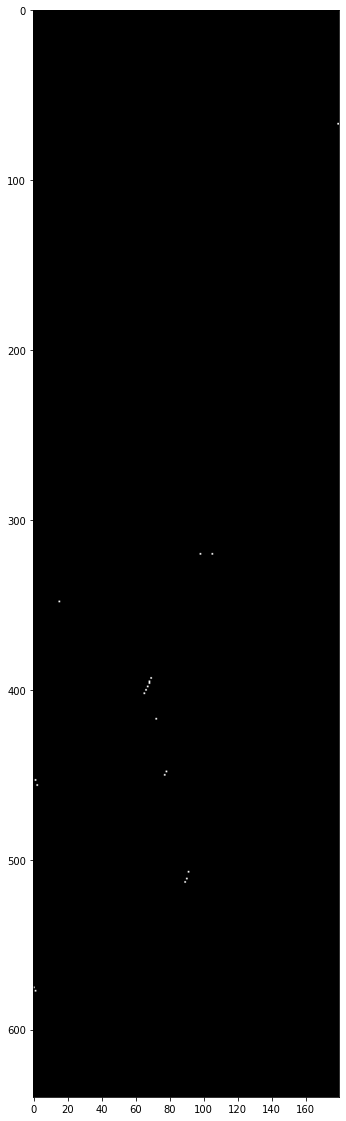

In [19]:
# Read image
img = cv2.imread("../thorino.jpg").astype(np.float32)

# Canny
edge = Canny(img)

# Hough
out = Hough_Line_step2(edge)

out = out.astype(np.uint8)

# Save result
plt.figure(figsize=(10, 20))
plt.imshow(out, cmap='gray')

cv2.imwrite('out45.jpg', out)

# 特にvotingが高い部分を抜き出せた

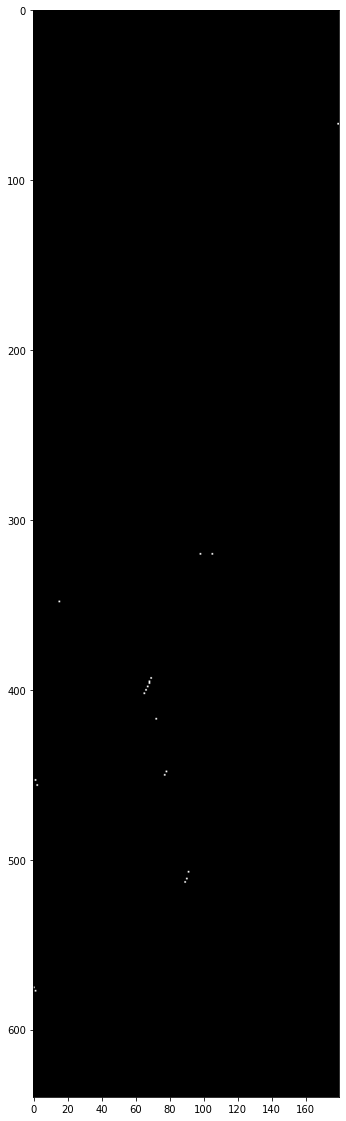

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def Canny(img):

	# Gray scale
	def BGR2GRAY(img):
		b = img[:, :, 0].copy()
		g = img[:, :, 1].copy()
		r = img[:, :, 2].copy()

		# Gray scale
		out = 0.2126 * r + 0.7152 * g + 0.0722 * b
		out = out.astype(np.uint8)

		return out


	# Gaussian filter for grayscale
	def gaussian_filter(img, K_size=3, sigma=1.3):

		if len(img.shape) == 3:
			H, W, C = img.shape
			gray = False
		else:
			img = np.expand_dims(img, axis=-1)
			H, W, C = img.shape
			gray = True

		## Zero padding
		pad = K_size // 2
		out = np.zeros([H + pad * 2, W + pad * 2, C], dtype=np.float)
		out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)

		## prepare Kernel
		K = np.zeros((K_size, K_size), dtype=np.float)
		for x in range(-pad, -pad + K_size):
			for y in range(-pad, -pad + K_size):
				K[y + pad, x + pad] = np.exp( - (x ** 2 + y ** 2) / (2 * sigma * sigma))
		#K /= (sigma * np.sqrt(2 * np.pi))
		K /= (2 * np.pi * sigma * sigma)
		K /= K.sum()

		tmp = out.copy()

		# filtering
		for y in range(H):
			for x in range(W):
				for c in range(C):
					out[pad + y, pad + x, c] = np.sum(K * tmp[y : y + K_size, x : x + K_size, c])

		out = np.clip(out, 0, 255)
		out = out[pad : pad + H, pad : pad + W]
		out = out.astype(np.uint8)

		if gray:
			out = out[..., 0]

		return out


	# sobel filter
	def sobel_filter(img, K_size=3):
		if len(img.shape) == 3:
			H, W, C = img.shape
		else:
			H, W = img.shape

		# Zero padding
		pad = K_size // 2
		out = np.zeros((H + pad * 2, W + pad * 2), dtype=np.float)
		out[pad : pad + H, pad : pad + W] = img.copy().astype(np.float)
		tmp = out.copy()

		out_v = out.copy()
		out_h = out.copy()

		## Sobel vertical
		Kv = [[1., 2., 1.],[0., 0., 0.], [-1., -2., -1.]]
		## Sobel horizontal
		Kh = [[1., 0., -1.],[2., 0., -2.],[1., 0., -1.]]

		# filtering
		for y in range(H):
			for x in range(W):
				out_v[pad + y, pad + x] = np.sum(Kv * (tmp[y : y + K_size, x : x + K_size]))
				out_h[pad + y, pad + x] = np.sum(Kh * (tmp[y : y + K_size, x : x + K_size]))

		out_v = np.clip(out_v, 0, 255)
		out_h = np.clip(out_h, 0, 255)

		out_v = out_v[pad : pad + H, pad : pad + W]
		out_v = out_v.astype(np.uint8)
		out_h = out_h[pad : pad + H, pad : pad + W]
		out_h = out_h.astype(np.uint8)

		return out_v, out_h


	def get_edge_angle(fx, fy):
		# get edge strength
		edge = np.sqrt(np.power(fx.astype(np.float32), 2) + np.power(fy.astype(np.float32), 2))
		edge = np.clip(edge, 0, 255)

		fx = np.maximum(fx, 1e-10)
		#fx[np.abs(fx) <= 1e-5] = 1e-5

		# get edge angle
		angle = np.arctan(fy / fx)

		return edge, angle


	def angle_quantization(angle):
		angle = angle / np.pi * 180
		angle[angle < -22.5] = 180 + angle[angle < -22.5]
		_angle = np.zeros_like(angle, dtype=np.uint8)
		_angle[np.where(angle <= 22.5)] = 0
		_angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
		_angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
		_angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

		return _angle


	def non_maximum_suppression(angle, edge):
		H, W = angle.shape
		_edge = edge.copy()
		
		for y in range(H):
			for x in range(W):
					if angle[y, x] == 0:
							dx1, dy1, dx2, dy2 = -1, 0, 1, 0
					elif angle[y, x] == 45:
							dx1, dy1, dx2, dy2 = -1, 1, 1, -1
					elif angle[y, x] == 90:
							dx1, dy1, dx2, dy2 = 0, -1, 0, 1
					elif angle[y, x] == 135:
							dx1, dy1, dx2, dy2 = -1, -1, 1, 1
					if x == 0:
							dx1 = max(dx1, 0)
							dx2 = max(dx2, 0)
					if x == W-1:
							dx1 = min(dx1, 0)
							dx2 = min(dx2, 0)
					if y == 0:
							dy1 = max(dy1, 0)
							dy2 = max(dy2, 0)
					if y == H-1:
							dy1 = min(dy1, 0)
							dy2 = min(dy2, 0)
					if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
							_edge[y, x] = 0

		return _edge

	def hysterisis(edge, HT=100, LT=30):
		H, W = edge.shape

		# Histeresis threshold
		edge[edge >= HT] = 255
		edge[edge <= LT] = 0

		_edge = np.zeros((H + 2, W + 2), dtype=np.float32)
		_edge[1 : H + 1, 1 : W + 1] = edge

		## 8 - Nearest neighbor
		nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

		for y in range(1, H+2):
				for x in range(1, W+2):
						if _edge[y, x] < LT or _edge[y, x] > HT:
								continue
						if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
								_edge[y, x] = 255
						else:
								_edge[y, x] = 0

		edge = _edge[1:H+1, 1:W+1]
								
		return edge

	# grayscale
	gray = BGR2GRAY(img)

	# gaussian filtering
	gaussian = gaussian_filter(gray, K_size=5, sigma=1.4)

	# sobel filtering
	fy, fx = sobel_filter(gaussian, K_size=3)

	# get edge strength, angle
	edge, angle = get_edge_angle(fx, fy)

	# angle quantization
	angle = angle_quantization(angle)

	# non maximum suppression
	edge = non_maximum_suppression(angle, edge)

	# hysterisis threshold
	out = hysterisis(edge, 100, 30)

	return out


def Hough_Line_step2(edge):
	## Voting
	def voting(edge):
		H, W = edge.shape
		
		drho = 1
		dtheta = 1

		# get rho max length
		rho_max = np.ceil(np.sqrt(H ** 2 + W ** 2)).astype(np.int)

		# hough table
		hough = np.zeros((rho_max * 2, 180), dtype=np.int)

		# get index of edge
		ind = np.where(edge == 255)

		## hough transformation
		for y, x in zip(ind[0], ind[1]):
				for theta in range(0, 180, dtheta):
						# get polar coordinat4s
						t = np.pi / 180 * theta
						rho = int(x * np.cos(t) + y * np.sin(t))

						# vote
						hough[rho + rho_max, theta] += 1
							
		out = hough.astype(np.uint8)

		return out

	# non maximum suppression
	def non_maximum_suppression(hough):
		rho_max, _ = hough.shape

		## non maximum suppression
		for y in range(rho_max):
			for x in range(180):
				# get 8 nearest neighbor
				x1 = max(x-1, 0)
				x2 = min(x+2, 180)
				y1 = max(y-1, 0)
				y2 = min(y+2, rho_max-1)
				if np.max(hough[y1:y2, x1:x2]) == hough[y,x] and hough[y, x] != 0:
					pass
					#hough[y,x] = 255
				else:
					hough[y,x] = 0

		# for hough visualization
		# get top-10 x index of hough table
		ind_x = np.argsort(hough.ravel())[::-1][:20]
		# get y index
		ind_y = ind_x.copy()
		thetas = ind_x % 180
		rhos = ind_y // 180
		_hough = np.zeros_like(hough, dtype=np.int)
		_hough[rhos, thetas] = 255

		return _hough

	# voting
	hough = voting(edge)

	# non maximum suppression
	out = non_maximum_suppression(hough)

	return out


# Read image
img = cv2.imread("../thorino.jpg").astype(np.float32)

# Canny
edge = Canny(img)

# Hough
out = Hough_Line_step2(edge)

out = out.astype(np.uint8)

# Save result
plt.figure(figsize=(10, 20))
plt.imshow(out, cmap='gray')